# Adding topography to geological models
***
This chapter shows how to make geological models look more realistic by incorporating topography data:
- The data can either be stored in a raster file that can be conveniently loaded into gempy.
- For demonstration purposes GemPy also provides a tool to create a random hilly landscape to limit the models on the surface.

***

In [1]:
import sys
sys.path.append("../..")

import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. The common procedure to set up a model:

In [2]:
geo_model = gp.create_model('Single_layer_topo')

gp.init_data(geo_model, extent=[440720, 441129, 69280,69689,-200,250],resolution = (50,50,50),
                         path_i = os.pardir+"/data/input_data/tut-ch1-7/onelayer_interfaces.csv",
                         path_o = os.pardir+"/data/input_data/tut-ch1-7/onelayer_orient.csv")



Single_layer_topo  2019-05-01 11:25

In [3]:
# use happy spring colors! 
geo_model.surfaces.colors.change_colors({'layer1':'#ff8000','basement':'#88cc60'})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,Default series,1,False,#ff8000,1
1,basement,Basement,1,True,#88cc60,2


In [4]:
%matplotlib inline
gp.map_series_to_surfaces(geo_model, {'series':('layer1','basement')})

,surface,series,order_surfaces,isBasement,color,id
0,layer1,series,1,False,#ff8000,1
1,basement,series,2,True,#88cc60,2


### 2. Adding topography

#### 2 a. Load from raster file

In [5]:
fp = os.pardir+"/data/input_data/tut-ch1-7/bogota.tif"

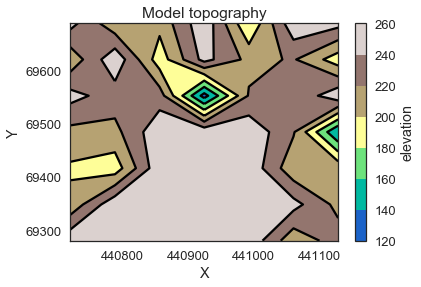

In [6]:
geo_model.set_topography(source='npy',filepath='test2.npy')

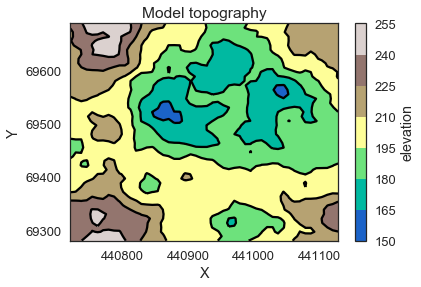

In [7]:
geo_model.set_topography(source='random')

In [11]:
geo_model.grid.topography.save('test3')

saved


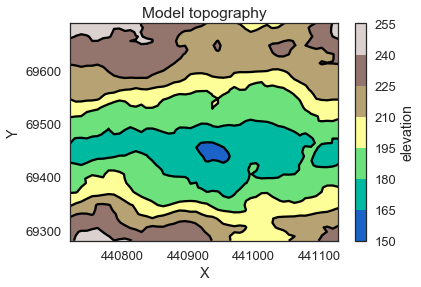

In [12]:
geo_model.set_topography(source='npy',filepath='test3.npy')

In [7]:
#plt.imshow(geo_model.grid.topography.topo.dem_zval)
#plt.colorbar()

#### 2.b create fun topography

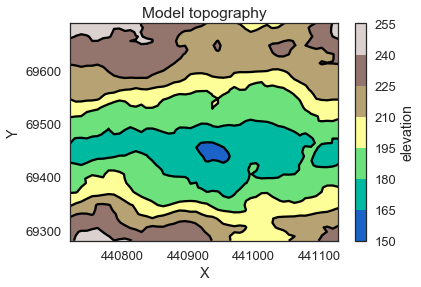

In [10]:
geo_model.set_topography(source='random')

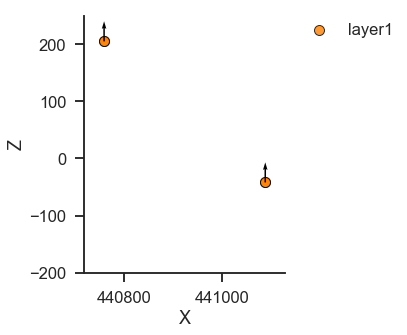

In [13]:
gp.plot.plot_data(geo_model)

In [10]:
gp.set_interpolation_data(geo_model,
                          output='geology', compile_theano=True,
                          theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [11]:
geo_model.surfaces.modify_order_surfaces(1,0)

In [12]:
sol = gp.compute_model(geo_model, compute_mesh=False,set_solutions=False)

In [13]:
from gempy.plot.visualization_2d import PlotData2D

In [14]:
plot=PlotData2D(geo_model)

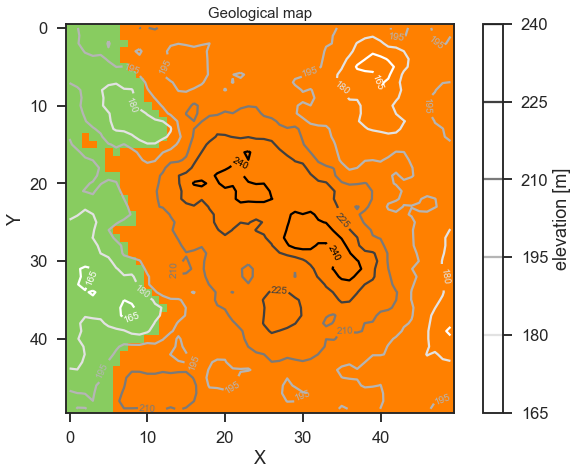

In [18]:
plot.plot_map(sol)

In [23]:
gp.compute_model(geo_model, compute_mesh=False,set_solutions=True)


Lithology ids 
  [ 2.  2.  2. ...,  1.  1.  1.] 

{'cmap': <matplotlib.colors.ListedColormap object at 0x000002684EDE3B00>, 'norm': <matplotlib.colors.Normalize object at 0x000002684EDE3E48>}


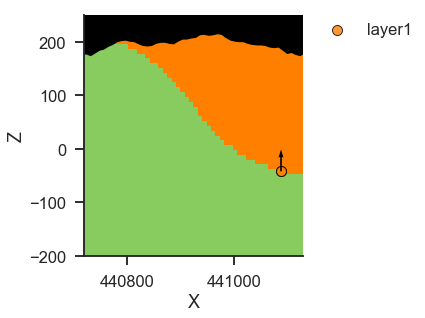

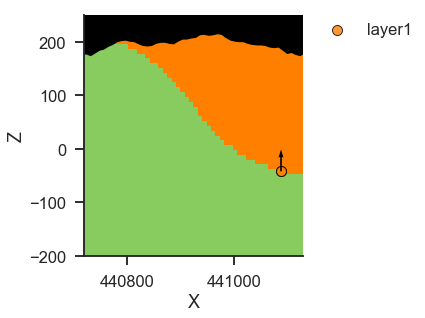

In [24]:
%matplotlib inline
plot.plot_block_section(geo_model, cell_number=42, block=geo_model.solutions.lith_block,
                         direction='y', plot_data=True,show_faults=False)